In [8]:
%matplotlib inline

from pyspark import SparkContext, SparkConf
from pyspark.sql import Row, SparkSession

In [9]:
spark = SparkSession.builder \
        .master("local") \
        .appName("recommender") \
        .getOrCreate()

## The MovieLens dataset

The MovieLens dataset (already available with this notebook, originally [here](https://grouplens.org/datasets/movielens/)) is a popular dataset used in recommendation engines research.
In this workshop we will use the "small" variant, consisting of 20000263 ratings for 27278 movies by 138493 users.
This dataset consist of several CSV files, namely
 * A ratings data file (`ratings.csv`)
 * A tags data file (`tags.csv`)
 * A movies data file (`movies.csv`)
 * A links data file (`links.csv`)
 * A tag genome (`genome-scores.csv` and `genome-tags.csv`)
 
 For the scope of this workshop, we are mainly interest in the rating and movies data files, which have, respectively, the following structure:
 The ratings data:
 * `userId`, a unique numerical user id
 * `movieId`, a unique numerical movie id
 * `rating`, a numerical rating, as an integer from $0$ to $5$
 * `timestamp`, a numerical timestamp (not used in this exercise)
 The movies data:
 * `movieId`, as above
 * `title`, the movie title
 * `genres` a string label with the movie genre (as listed [here](http://files.grouplens.org/datasets/movielens/ml-20m-README.html)).
 
 ### Loading the data
 
 We start by using Apache Spark's built in functionality to load text files into the Spark cluster, `.textFile()` (documented [here](http://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.SparkContext.textFile)), which will return an `RDD` of strings.
 Since `.textFile()` will read each row in the CSV file as an RDD entry, we further process it by then splitting each row into a list of CSV entries and keep only the relevant fields (i.e. `userId`, `movieId` and `rating` for the ratings, and `movieId` and `title` for the movies file).

In [23]:
def load_data(path, header, token_fun):
    """Loads the CSV file, strips the header and keeps only the specified fields"""
    rows = spark.sparkContext.textFile(path).filter(lambda x: x!=header).map(lambda x: x.split(",")).map(token_fun)
    return spark.createDataFrame(rows)
    
    

movies = load_data('ml-latest-small/movies.csv', 
                   'movieId,title,genres', 
                   lambda tokens: Row(item=int(tokens[0]),title=tokens[1]))

ratings = load_data('ml-latest-small/ratings.csv', 
                    'userId,movieId,rating,timestamp', 
                    lambda tokens: Row(user=int(tokens[0]), item=int(tokens[1]), rating=float(tokens[2])))

In [24]:
print("Number of movies: {}".format(movies.count()))
print("Number of ratings: {}".format(ratings.count()))
movies.take(5)

Number of movies: 9742
Number of ratings: 100836


[Row(item=1, title='Toy Story (1995)'),
 Row(item=2, title='Jumanji (1995)'),
 Row(item=3, title='Grumpier Old Men (1995)'),
 Row(item=4, title='Waiting to Exhale (1995)'),
 Row(item=5, title='Father of the Bride Part II (1995)')]

We can now start by exploring the data.
Let's look at the ratings distribution:

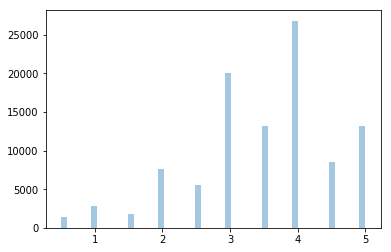

In [25]:
import seaborn as sns

r = ratings.select('rating').collect()
sns.distplot(r, kde=False)

## Training the model

To train Spark's ALS model, we need to perform a few steps.
The first step is to define a metric to quantify "how good" our model is. This is done by chosing an error measure, which typically is the _mean squared error_ (MSE). The mean square error is formally defined by

$$
\text{MSE} = \frac{1}{N}\sum_{i=1}^{N}\epsilon_i^2, \qquad \epsilon_i = r_i - \hat{r}_i.
$$

That is, we first calculate the difference, $\epsilon_i$, between each pair of true rating ($r_i$) and it's corresponding _predicted_ rating ($\hat{r}_i$) and then calculated the average of the square of these errors. As example, consider a list of ratings `r1` and corresponding predictiong `r2`:

In [26]:
r1 = [4.5, 3.0, 1.0, 5.0, 4.0]
r2 = [4.56, 2.9, 1.1, 4.9, 3.2]

In [27]:
def mse(r, p):
    return sum([(pair[0] - pair[1])**2 for pair in zip(r, p)]) / len(r)

print("MSE = {}".format(mse(r1, r2)))

MSE = 0.13471999999999992


Since we've established our error measure, we can proceed to the next step.
We now need to split our data into a _training_, _test_ and _validation_ subsets.
We will use respectively the proportions 63%, 18% and 18%.

In [28]:
def split_sets(ratings, proportions):
    split = ratings.randomSplit(proportions, seed=42)
    return {'training': split[0], 'validation': split[1], 'test': split[2]}
    
sets = split_sets(ratings, [0.63212056, 0.1839397, 0.1839397])
print("Training dataset size = {}".format(sets['training'].count()))
print("Validation dataset size = {}".format(sets['validation'].count()))
print("Test dataset size = {}".format(sets['test'].count()))

Training dataset size = 63952
Validation dataset size = 18559
Test dataset size = 18325


### Parameter estimation

We add the `coldStartStrategy` to the ALS class so that we automatically drop any `NaN` predictions.

In [49]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

als = ALS(coldStartStrategy="drop")

param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [6, 8, 10, 12]) \
    .addGrid(als.maxIter,[6, 8, 10, 12]) \
    .build()

evaluator = RegressionEvaluator(
    metricName="mse",
    labelCol="rating")

tvs = TrainValidationSplit(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
)

model = tvs.fit(sets['training'])

In [53]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col

prediction = model.transform(sets['test'])

# Round floats to whole numbers
prediction = prediction.withColumn("prediction", F.abs(F.round(prediction["prediction"],0)))

prediction.alias('p').join(movies.alias('m'), col('p.item') == col('m.item')) \
    .select([col('p.user'), col('m.title'), col('p.prediction'), col('p.rating')]).show(100, truncate=False)

+----+------------------------------------------------+----------+------+
|user|title                                           |prediction|rating|
+----+------------------------------------------------+----------+------+
|599 |Othello (1995)                                  |3.0       |2.5   |
|40  |Othello (1995)                                  |4.0       |4.0   |
|68  |Othello (1995)                                  |3.0       |3.0   |
|606 |"City of Lost Children                          |4.0       |4.5   |
|599 |"City of Lost Children                          |3.0       |3.5   |
|171 |"City of Lost Children                          |5.0       |5.0   |
|95  |"City of Lost Children                          |4.0       |5.0   |
|323 |"City of Lost Children                          |4.0       |3.5   |
|221 |"City of Lost Children                          |4.0       |4.5   |
|600 |"City of Lost Children                          |4.0       |4.5   |
|66  |"City of Lost Children          

AttributeError: 'ALSModel' object has no attribute 'predictAll'

In [ ]:
from pyspark.mllib.recommendation import ALS
rank = 10
iterations = 10
seed = 42
model = ALS.train(sets['training'], rank, seed=seed, iterations=iterations)

In [ ]:
validation = sets['validation'].map(lambda x: (x[0], x[1]))
validation.take(5)

In [ ]:
predictions = model.predictAll(validation)
predictions.take(10)